In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # For loading the videofile and plotting bounding boxes
import os # For loading datafiles
from matplotlib import pyplot as plt # For plotting the annotations

# Input data files are available in the "../input/" directory.
# Loading data, the data is semicolon seperated.

df_valid  = pd.read_csv("data/annotations/annotations_AAU/valid.csv", sep=";")
df_train = pd.read_csv("data/annotations/annotations_AAU/train.csv", sep=";")
df_test = pd.read_csv("data/annotations/annotations_AAU/test.csv", sep=";")


In [3]:
df_valid

,Filename,Object ID,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y
0,2019-02-21_06-52-16to2019-02-21_06-52-34_1-003...,3,starfish,431,459,475,505
1,2019-03-06_22-11-06to2019-03-06_22-11-17_1-015...,33,crab,640,365,680,385
2,2019-03-06_22-11-06to2019-03-06_22-11-17_1-015...,34,crab,735,325,758,350
3,2019-03-06_22-11-06to2019-03-06_22-11-17_1-015...,35,crab,733,487,762,516
4,2019-03-06_22-11-06to2019-03-06_22-11-17_1-015...,141,crab,798,502,830,533
...,...,...,...,...,...,...,...
3576,2019-03-20_06-00-48to2019-03-20_06-00-56_1-009...,7,crab,374,311,418,338
3577,2019-02-26_00-44-33to2019-02-26_00-44-47_1-002...,17,starfish,371,413,397,479
3578,2019-02-26_00-44-33to2019-02-26_00-44-47_1-002...,108,starfish,252,449,301,490
3579,2019-03-19_11-42-56to2019-03-19_11-43-14_1-015...,24,fish,1,95,98,212


In [ ]:
from ultralytics import YOLO

CONFIGS = {
    "weak": "config/albumentations_weak.yaml",
    "medium": "config/albumentations_medium.yaml",
    "strong": "config/albumentations_strong.yaml",
}

def train_experiment(name, aug_cfg):
    model = YOLO("yolov8s.pt")

    model.train(
        data="data/dataset.yaml",
        epochs=100,
        imgsz=960,
        batch=8,
        device=0,
        workers=8,
        patience=20,

        augment=True,
        albumentations=aug_cfg,

        project="runs/augmentation_study",
        name=name
    )

if __name__ == "__main__":
    for exp_name, cfg in CONFIGS.items():
        train_experiment(exp_name, cfg)

Ultralytics 8.4.4 🚀 Python-3.11.14 torch-2.9.1 


ValueError: Invalid CUDA 'device=0' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: None
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


In [26]:
import cv2
from pathlib import Path

def extract_frame(video_path, frame_num, output_path):
    cap = cv2.VideoCapture(video_path)

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()

    if not ret:
        raise RuntimeError("Error while img reading")

    frame = cv2.resize(frame, (960, 540))
    cv2.imwrite(output_path, frame)
    cap.release()

video = "data/dataset/videos/fish-big/2019-02-22_22-11-57to2019-02-22_22-12-10_1.avi"

extract_frame(
    video_path=video,
    frame_num=59,
    output_path="example.png"
)

/var/folders/2p/1g0tbznd1zg9118y89qrclsc0000gn/T/ipykernel_28599/2446248381.py:14: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  transforms.append(getattr(A, name)(**params))


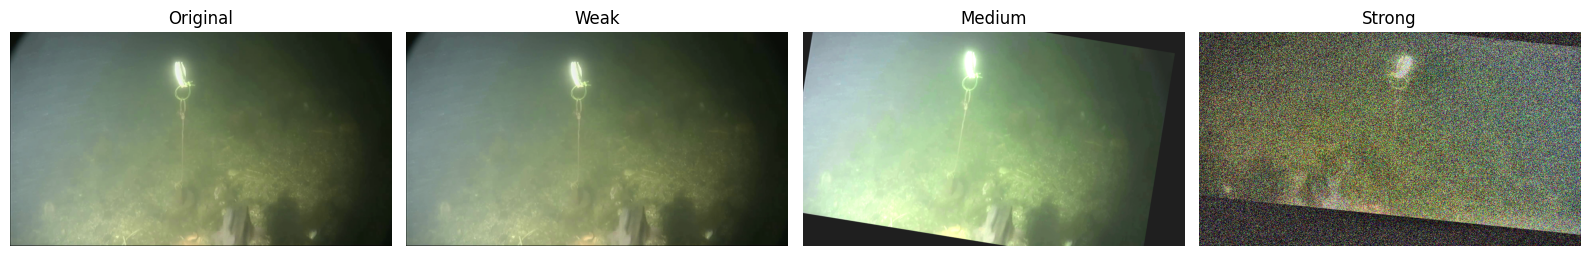

In [22]:
import cv2
import albumentations as A
import matplotlib.pyplot as plt
import yaml

def load_pipeline(config_path):
    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    transforms = []
    for t in cfg["train"]:
        name = list(t.keys())[0]
        params = t[name] or {}
        transforms.append(getattr(A, name)(**params))

    return A.Compose(transforms)

def show_augmentations(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pipelines = {
        "Original": None,
        "Weak": load_pipeline("config/albumentations_weak.yaml"),
        "Medium": load_pipeline("config/albumentations_medium.yaml"),
        "Strong": load_pipeline("config/albumentations_strong.yaml"),
    }

    plt.figure(figsize=(16, 4))

    for i, (name, aug) in enumerate(pipelines.items()):
        plt.subplot(1, 4, i + 1)

        if aug is None:
            aug_image = image
        else:
            aug_image = aug(image=image)["image"]

        plt.imshow(aug_image)
        plt.title(name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()
show_augmentations("example.png")